<a href="https://colab.research.google.com/github/djzhendogg/Generative-Models-2025-ITMO/blob/main/Assignment%202/2_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.\


Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST

from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [ ]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.5MB/s]


Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542488, -0.60313725, -0.47084969,
        -0.33856213, -0.20627451, -0.07398695,  0.05830061,  0.19058824,
         0.32287574,  0.45516336,  0.58745098,  0.71973848,  0.8520261 ,
         0.98431373]),
 <BarContainer object of 15 artists>)

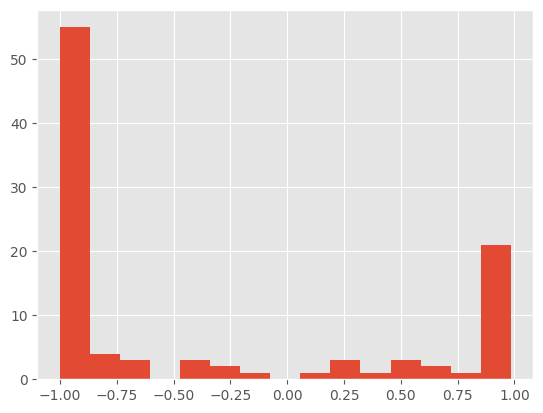

In [ ]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return x.add(1).div(2).clamp(0, 1)

In [ ]:
# show image sample with matplotlib

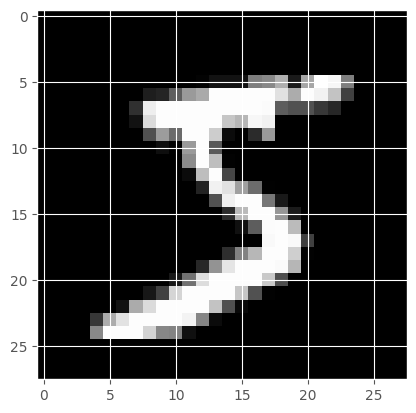

In [ ]:
plt.imshow(img[0], cmap='gray')

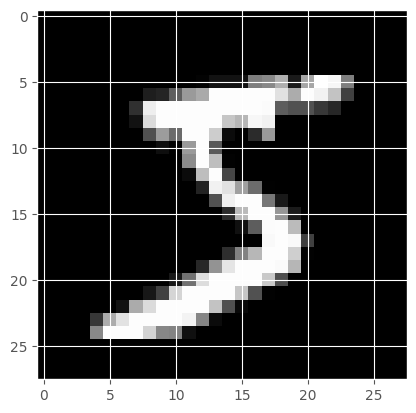

In [ ]:
plt.imshow(denorm(img)[0], cmap='gray')

In [ ]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(mnist_dataset, shuffle=True, batch_size=batch_size)


### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.tanh(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.sigmoid(x)
        return x

### Create the Generator and Discriminator

In [ ]:
# create new Generator model

G = Generator(latent_size, image_size, hidden_size)

# create new Discriminator model

D = Discriminator(image_size, hidden_size)

In [ ]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))
y

tensor([[-0.0520, -0.0290, -0.0195,  ..., -0.1477,  0.0985, -0.0176],
        [-0.0059,  0.0176,  0.0173,  ..., -0.0995,  0.0420, -0.0145]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [ ]:
y.shape

torch.Size([2, 784])

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## Define the optimizer for generator and discrimator
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR)
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR)

Discriminator Training

In [ ]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    real_score = D_model(images)
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    fake_score = D_model(fake_images)
    d_loss_fake = criterion(fake_score, fake_labels)

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [ ]:
def train_generator(G_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    g_loss = criterion(D(fake_images), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()

    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [ ]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, _ = train_generator(G)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.0997, g_loss: 5.2195, D(x): 0.95, D(G(z)): 0.02
Epoch [0/300], Step [400/600], d_loss: 0.7120, g_loss: 3.0903, D(x): 0.72, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.3282, g_loss: 2.1358, D(x): 0.87, D(G(z)): 0.12
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3985, g_loss: 3.0005, D(x): 0.91, D(G(z)): 0.21
Epoch [1/300], Step [400/600], d_loss: 0.1318, g_loss: 3.8598, D(x): 0.96, D(G(z)): 0.07
Epoch [1/300], Step [600/600], d_loss: 0.9182, g_loss: 1.6672, D(x): 0.77, D(G(z)): 0.32
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3326, g_loss: 3.3960, D(x): 0.90, D(G(z)): 0.13
Epoch [2/300], Step [400/600], d_loss: 0.7972, g_loss: 1.8254, D(x): 0.78, D(G(z)): 0.29
Epoch [2/300], Step [600/600], d_loss: 2.3427, g_loss: 0.9724, D(x): 0.44, D(G(z)): 0.46
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3916, g_loss: 3.3216, D(x): 0.84, D(G(z)): 0.11
Epoch [3/300], Step [400/6

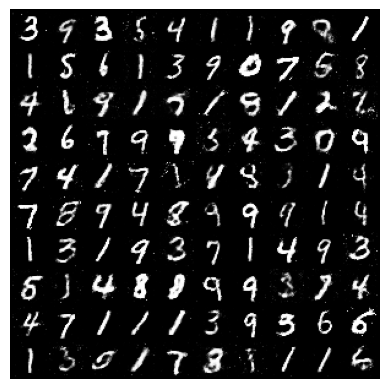

In [ ]:
# show output after epochs training
plt.imshow(Image.open(os.path.join(sample_dir, "fake_images-0225.png")))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

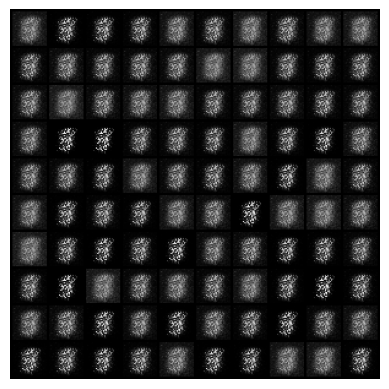

In [ ]:
plt.imshow(Image.open(os.path.join(sample_dir, "fake_images-0005.png")))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

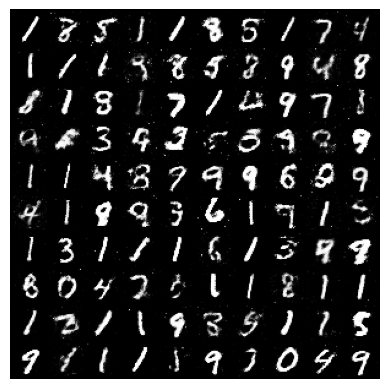

In [ ]:
plt.imshow(Image.open(os.path.join(sample_dir, "fake_images-0150.png")))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

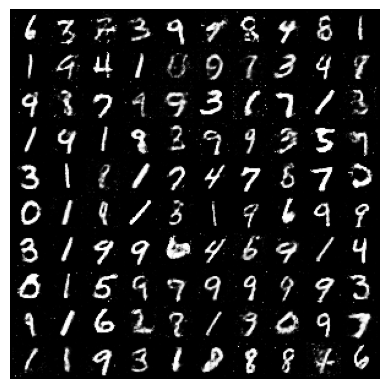

In [ ]:
plt.imshow(Image.open(os.path.join(sample_dir, "fake_images-0300.png")))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

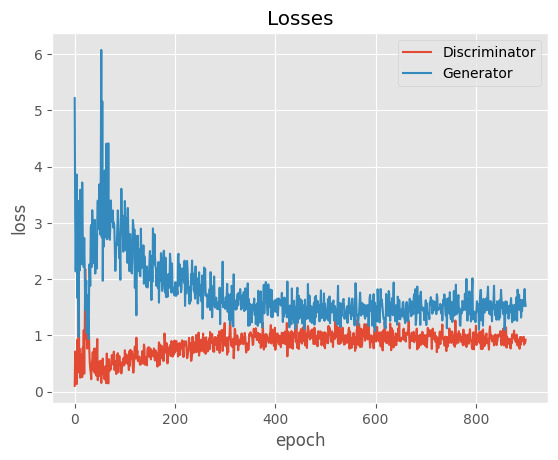

In [ ]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

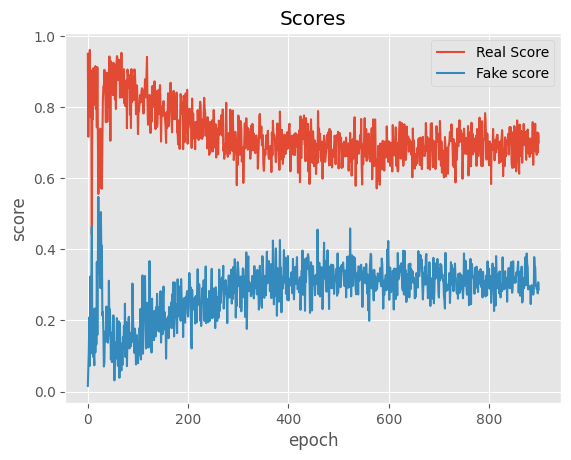

In [ ]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

In [ ]:
%%shell
zip -r images.zip ./images

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [2]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124187, -0.74797386, -0.68470585, -0.62143791,
        -0.55816996, -0.49490196, -0.43163398, -0.368366  , -0.30509806,
        -0.24183005, -0.17856205, -0.1152941 , -0.05202615,  0.01124185,
         0.07450986]),
 <BarContainer object of 15 artists>)

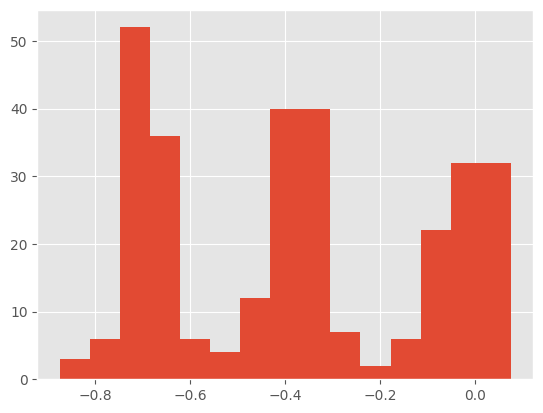

In [ ]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

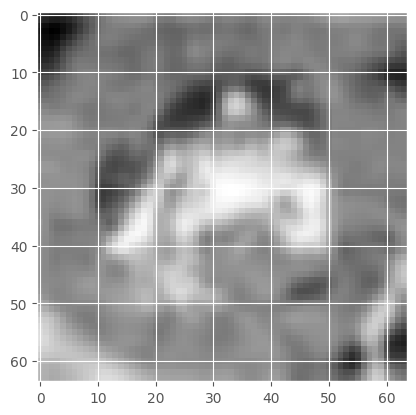

In [ ]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return img.add(1).div(2).clamp(0, 1)

# show  image sample with matplotlib
plt.imshow(denorm(img[0]), cmap='gray')

(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([0.06274509, 0.09437908, 0.12601307, 0.15764706, 0.18928105,
        0.22091503, 0.25254902, 0.28418303, 0.315817  , 0.34745097,
        0.37908497, 0.41071898, 0.44235295, 0.47398692, 0.50562096,
        0.53725493]),
 <BarContainer object of 15 artists>)

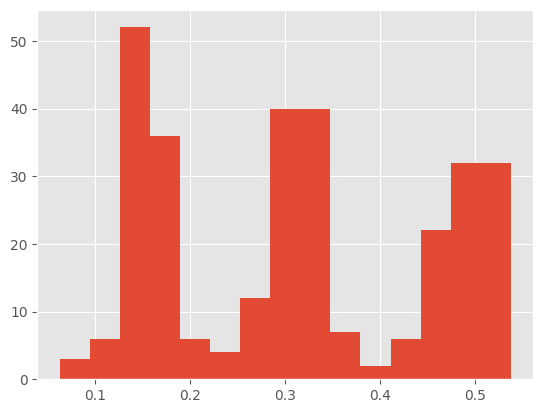

In [ ]:
plt.hist(denorm(img[:, 5:15, 5:15]).flatten(), bins=15)

In [ ]:
# create the dataloader
data_loader = torch.utils.data.DataLoader(cifar_dataset, shuffle=True, batch_size=CFG.batch_size)

### DCGAN implementation

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        self.conv_seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv_seq(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky -
        # conv2d - batchnorm - leaky -
        # conv2d - batchnorm - leaky -
        # conv - batchnorm - leaky -
        # conv2d
        super(DCDiscriminator, self).__init__()
        ##
        self.conv_seq = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_seq(x).view(-1, 1)

In [ ]:
# create new Generator model

DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model

DCD = DCDiscriminator(CFG.nc, CFG.ndf)

In [ ]:
from torchsummary import summary
summary(DCG.to(CFG.device), (CFG.nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,712
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,075
             Tanh-14            [-1, 3,

In [ ]:
summary(DCD.to(CFG.device), (CFG.nc, CFG.image_size, CFG.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [ ]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1).to(CFG.device))

In [ ]:
y[0].shape

torch.Size([3, 64, 64])

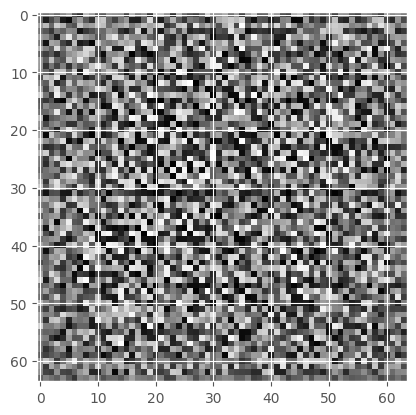

In [ ]:
plt.imshow(denorm(y)[0][0].to('cpu').detach(), cmap='gray')

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
g_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr)
d_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr)

In [ ]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)

    # Loss for real images
    real_score = D_model(images)
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    z = torch.randn(images.size(0), CFG.nz, 1, 1).to(device) # Use CFG.nz and 4D shape
    fake_images = G_model(z)
    fake_score = D_model(fake_images).detach() # Detach fake images for discriminator training
    d_loss_fake = criterion(fake_score, fake_labels)

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [ ]:
def train_generator(D_model, G_model): # Pass D_model as argument
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(device) # Use CFG.nz and 4D noise
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    g_loss = criterion(D_model(fake_images), labels) # Use D_model (DCDiscriminator)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()

    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [ ]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [ ]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(device) # Removed flattening: images is now 4D

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(DCD, DCG, images)


        # Train the generator
        g_loss, _ = train_generator(DCD, DCG) # Pass DCD as discriminator model, and DCG as generator model

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1) # Corrected function call to pass DCG model

Epoch [0/300], Step [200/391], d_loss: 0.0014, g_loss: 13.5634, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [1/300], Step [200/391], d_loss: 0.0009, g_loss: 10.8838, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [2/300], Step [200/391], d_loss: 0.0077, g_loss: 9.2911, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300], Step [200/391], d_loss: 0.0186, g_loss: 9.1488, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [4/300], Step [200/391], d_loss: 0.6696, g_loss: 4.8538, D(x): 0.91, D(G(z)): 0.31
Saving fake_images-0005.png
Epoch [5/300], Step [200/391], d_loss: 0.0212, g_loss: 2.8738, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0006.png
Epoch [6/300], Step [200/391], d_loss: 0.5320, g_loss: 6.6846, D(x): 0.76, D(G(z)): 0.01


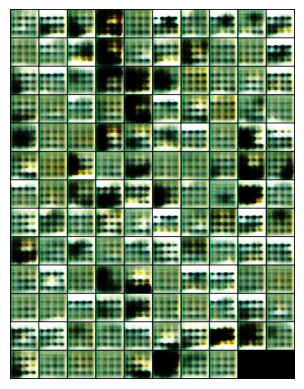

In [3]:
plt.imshow(Image.open('/content/fake_images-0006.png'))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

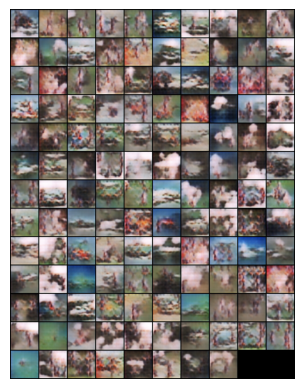

In [4]:
plt.imshow(Image.open('/content/fake_images-0036.png'))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

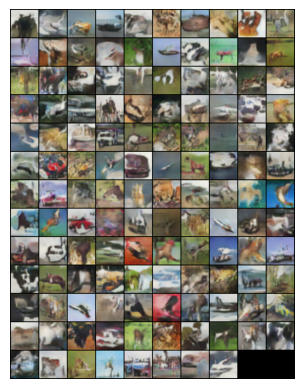

In [5]:
plt.imshow(Image.open('/content/fake_images-0112.png'))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

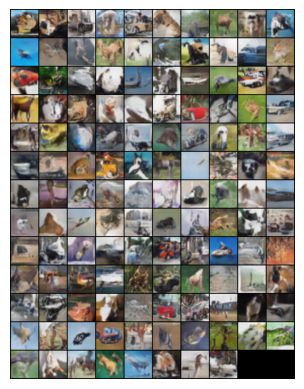

In [6]:
plt.imshow(Image.open('/content/fake_images-0300.png'))
plt.axis('off') # Hide axes for cleaner image display
plt.show()

In [8]:
d_losses = np.load('/content/d_losses.npy')
g_losses = np.load('/content/g_losses.npy')
real_scores = np.load('/content/real_scores.npy')
fake_scores = np.load('/content/fake_scores.npy')

Text(0.5, 1.0, 'Losses')

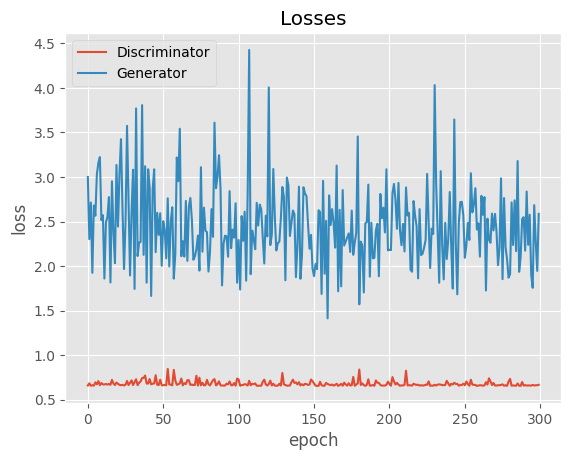

In [13]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")

Text(0.5, 1.0, 'Scores')

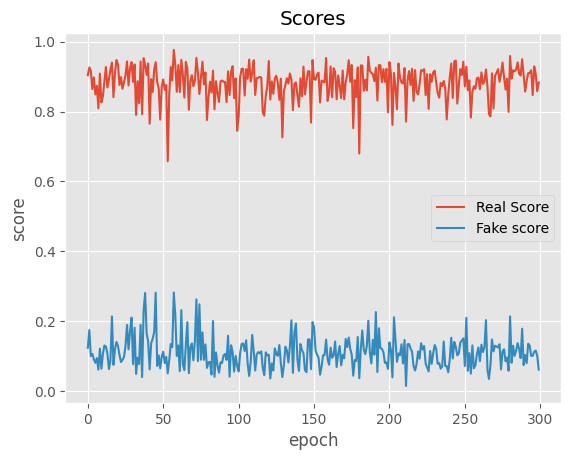

In [12]:
# show the discrimator loss and generator loss
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores")